# Urban blocks

## Imports & Parameters

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import rasterio
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import shape

In [2]:
# Add local module to the path
src = os.path.abspath('../src')
if src not in sys.path:
    sys.path.append(src)

In [3]:
from metadata import City, CITIES
from landsat import Scene
from raster import euclidean_distance

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
def pretty(city_id):
    """formatmat city label."""
    name = city_id.title()
    name = name.replace('_', '-')
    return name

In [6]:
# Plotting style
plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rc('font', family='serif', serif='cmr10', size=12)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('figure', titlesize=12)
plt.rc('text', usetex=True)

## Data availability

### Road network

In [7]:
road_network = pd.Series(index=CITIES)

for city_name in CITIES:
    
    city = City(city_name)
    roads = city.roads
    area_of_interest = shape(city.aoi)
    road_network.loc[city_name] = round(np.sum(roads.length) * 1e-3)

In [8]:
road_network.sort_values(ascending=False)

johannesburg    14777.0
nairobi          6057.0
kampala          5198.0
antananarivo     4981.0
dakar            4772.0
windhoek         3173.0
katsina          1707.0
gao               940.0
saint_louis       881.0
chimoio           621.0
dtype: float64

Only three case studies have a road network that does not reach 1000km (Gao, Saint-Louis and Chimoio).

### Urban blocks

In [9]:
availability = pd.Series(index=CITIES)

for city_name in CITIES:
    
    city = City(city_name)
    availability.loc[city_name] = len(city.blocks)

In [10]:
availability.sort_values(ascending=False)

dakar           20725.0
johannesburg    20011.0
nairobi          4285.0
katsina          3791.0
kampala          2671.0
antananarivo     2238.0
windhoek         1630.0
gao              1191.0
saint_louis      1129.0
chimoio           681.0
dtype: float64

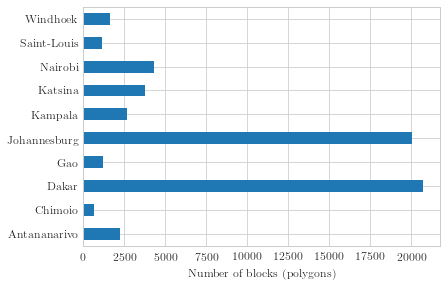

In [11]:
availability.index = availability.index.map(pretty)
availability.plot(kind='barh', color='C0')
plt.xlabel('Number of blocks (polygons)');

## Block size

In [12]:
surfaces = np.arange(1, 50, 1)  # In hectares
spectral_distance = pd.DataFrame(index=CITIES, columns=surfaces)
count = pd.DataFrame(index=CITIES, columns=surfaces)

#progress = tqdm(total=len(CITIES) * len(surfaces))

for city_name in CITIES:
    
    city = City(city_name)
    scene = Scene(city.landsat_dir)
    blocks_sizes = city.blocks_raster
    
    bu = city.reference == 1
    sign_ref = scene.signature(bu)
    
    for max_ha in surfaces:
        
        blocks = (blocks_sizes > 0) & (blocks_sizes <= max_ha)
        count.at[(city_name, max_ha)] = np.count_nonzero(blocks)
        
        if np.count_nonzero(blocks) == 0:
            #progress.update(1)
            continue
        
        sign_blocks = scene.signature(blocks)
        spectral_distance.at[(city_name, max_ha)] = euclidean_distance(sign_blocks, sign_ref)
        #progress.update(1)
    
#progress.close()

In [13]:
spectral_distance

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
antananarivo,0.057157,0.0551338,0.0535411,0.05467,0.0554505,0.0561755,0.0568587,0.0558686,0.0565068,0.0559019,...,0.0600958,0.0601155,0.0603103,0.0598197,0.0594416,0.0592708,0.0599027,0.0595463,0.0595684,0.0596977
chimoio,0.00914297,0.00731652,0.00431202,0.00337915,0.00383152,0.00389587,0.00380557,0.00427325,0.00427709,0.00499892,...,0.00855244,0.00855244,0.00855244,0.00855244,0.00855244,0.00855244,0.00855244,0.00968699,0.00968699,0.00968699
dakar,0.105136,0.119337,0.138499,0.142422,0.153815,0.162937,0.169338,0.169186,0.168592,0.171284,...,0.18402,0.18402,0.183236,0.183236,0.182494,0.181969,0.185133,0.184639,0.184639,0.184639
gao,0.0562385,0.0615751,0.0628295,0.062762,0.0641055,0.0657371,0.0674504,0.0685822,0.0697178,0.0705505,...,0.0728214,0.0728214,0.0728214,0.0728214,0.0728214,0.0728214,0.0728214,0.0728214,0.0728214,0.0728214
johannesburg,0.0331009,0.0204789,0.0121353,0.0100296,0.0104815,0.0111296,0.0111896,0.0112234,0.0112349,0.0113571,...,0.0119114,0.0119545,0.0119568,0.0119693,0.0119932,0.0120367,0.0120586,0.0120986,0.0121487,0.0121914
kampala,0.0498616,0.0489155,0.049137,0.0503188,0.0512234,0.0541451,0.0545115,0.0546429,0.0553646,0.0557522,...,0.0678096,0.067934,0.0681069,0.068334,0.0684101,0.0688864,0.0688864,0.0692604,0.0696412,0.0698968
katsina,0.0167966,0.00778687,0.00358418,0.00386956,0.00644564,0.00823581,0.00948914,0.0106313,0.012115,0.0126502,...,0.0273705,0.0273705,0.0273705,0.0273705,0.0273705,0.0273705,0.0273705,0.0273705,0.0294499,0.0294499
nairobi,0.0177951,0.0301007,0.0371539,0.0437731,0.0481881,0.0516768,0.0539649,0.0556215,0.0580004,0.0604239,...,0.0796003,0.0797456,0.0812316,0.0811078,0.081241,0.0814022,0.0813959,0.0814951,0.0815585,0.0822738
saint_louis,0.025036,0.0276386,0.0283406,0.0277991,0.0286972,0.0281951,0.0303831,0.030803,0.0299331,0.0304362,...,0.0422985,0.0422985,0.0422985,0.0422985,0.0422985,0.0422985,0.0424491,0.0424491,0.0424491,0.0424491
windhoek,0.0388322,0.0252509,0.0260468,0.0285812,0.0289521,0.0311077,0.0311819,0.0329255,0.0328528,0.0337877,...,0.0417496,0.0417496,0.0417496,0.0413527,0.0413527,0.0407987,0.0407987,0.0407987,0.0407987,0.0407987


In [14]:
count

,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,49
antananarivo,3581,9415,14816,20095,24839,29285,32283,34876,37223,40955,...,90615,91069,91987,92451,93423,94407,97956,99505,100034,101653
chimoio,2174,4771,6314,7414,8238,8841,9260,9521,9620,10245,...,15411,15411,15411,15411,15411,15411,15411,15925,15925,15925
dakar,72867,88095,95029,99052,102489,105705,108257,110834,112803,114946,...,137758,137758,138219,138219,138706,139194,140196,140707,140707,140707
gao,4927,8838,9396,9556,9944,10179,10463,10629,10726,10835,...,11651,11651,11651,11651,11651,11651,11651,11651,11651,11651
johannesburg,37895,121115,195360,257510,306097,340002,365369,383383,398791,411157,...,565092,567780,568707,570114,571066,575024,577051,580666,584367,587596
kampala,3003,11336,19274,27764,34892,41692,47374,53847,59196,64361,...,143252,144601,145066,146491,146976,148462,148462,148974,149499,150594
katsina,12515,17862,20682,22257,23353,24069,24418,24840,25030,25237,...,30388,30388,30388,30388,30388,30388,30388,30388,30920,30920
nairobi,9362,21229,32066,40773,48593,55702,61577,67170,72676,78372,...,159108,160012,162776,164671,166134,168601,169621,170659,172236,173853
saint_louis,4145,5608,6502,7012,7456,7575,7850,8089,8180,8284,...,10428,10428,10428,10428,10428,10428,10931,10931,10931,10931
windhoek,3434,11041,16398,20145,22156,24770,26197,27682,29203,30480,...,46954,46954,46954,47426,47426,47928,47928,47928,47928,47928


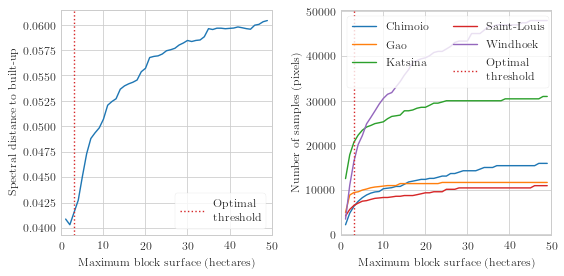

In [17]:
f, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(spectral_distance.mean(axis=0))
axes[0].set_xlim(0, 50)
axes[0].set_xlabel('Maximum block surface (hectares)')
axes[0].set_ylabel('Spectral distance to built-up')
axes[0].axvline(x=3, color='C3', linestyle=':', label='Optimal\nthreshold')
axes[0].legend(frameon=True)

for city in ['chimoio', 'gao', 'katsina', 'saint_louis', 'windhoek']:
    axes[1].plot(count.loc[city], label=pretty(city))

axes[1].set_xlim(0, 50)
axes[1].set_xlabel('Maximum block surface (hectares)')
axes[1].set_ylabel('Number of samples (pixels)')
axes[1].axvline(x=3, color='C3', linestyle=':', label='Optimal\nthreshold')
axes[1].legend(frameon=True, ncol=2, loc='upper left')

f.tight_layout()
f.savefig('../paper/figures/urban_blocks.pdf')
f.savefig('../paper/figures/urban_blocks.png');